# Introduction
Hello people, welcome to this kernel. In this kernel I am going to generate monet paintings using monet paintings (300) and random normal images (7K+) 

Before starting, I want to say that, I wrote this kernel for learning what is CycleGAN and how it works, so I've used this kernel:

https://www.kaggle.com/amyjang/monet-cyclegan-tutorial

All the code of this kernel is same with the tutorial. So, if you don't know what is CycleGAN and want to learn, you should check the tutorial.

So let's get started.

# Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import cv2



* In this kernel, we'll use Tensorflow as deep learning library.

# Loading Data

In [2]:
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))



Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [3]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# Building Generator

In [5]:
# rgb
OUT_CHANNELS = 3

def downsample(filters,size,apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters,size,strides=2,padding="same",kernel_initializer=initializer,use_bias=False))
    
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
        
    result.add(layers.LeakyReLU())
    
    return result


def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters,size,strides=2,padding="same",kernel_initializer=initializer,use_bias=False))
    
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
        
    result.add(layers.ReLU())
    
    return result

First, we defined downsample and upsample layers, thanks to these layers we downsample and upsample data in generator and discriminator.

In [6]:
def Generator():
    inputs = layers.Input([256,256,3])
    
    # bs = batch size
    down_stack = [
        downsample(64,4,apply_instancenorm=False),
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0.,0.02)
    last = layers.Conv2DTranspose(OUT_CHANNELS,4,strides=2,padding="same",kernel_initializer=initializer,activation="tanh")
    
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = layers.Concatenate()([x,skip])
        
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs,outputs=x)

* In order to avoid vanishing gradient problem we concatenated layers using skip connections.

# Building Discriminator

In [7]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    inp = layers.Input(shape=(256,256,3),name="input_image")
    
    x = inp
    
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128,4)(down1)
    down3 = downsample(256,4)(down2)
    
    zero_pad1 = layers.ZeroPadding2D()(down3)
    
    conv = layers.Conv2D(512,4,strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1)
    
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    
    last = layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=inp,outputs=last)

    
    

* Discriminator is a CNN based classifier, it takes an image with shape 256x256x3 and determines whether the image is real or not.

* We used LeakyReLU in order to avoid vanishing gradient problem.
* And we used Instance normalization instead of BatchNormalization.

In [8]:
# creating generators and discriminators using functions

monet_generator = Generator()
photo_generator = Generator()

monet_discriminator = Discriminator()
photo_discriminator = Discriminator()



* There are 4 networks in a CycleGAN:

    1. Monet Generator: Creates monet style images using photos.
    1. Photo Geneartor: Creates photos using monet stlye images
    1. Monet Discriminator: Determines whether the monet image is real or generated
    1. Photo Discriminator: Determines whether the photo is real or generated.

# CycleGAN Model

In [9]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

* There are 8 type of data in a CycleGAN:
    1. Real Photos: Real photos from the dataset
    1. Real Monet Style Images: Real monet paintings from the dataset
    1. Generated Photos (using Monet Style Images)
    1. Generated Monet Style Images (using Photos)
    1. Cycled Photos: Real Photo => Monet Generator => Generated Monet => Photo Generator => Photo
    1. Cycled Monet Style Images: Real Monet => Photo Generator => Generated Photo => Monet Generator => Monet
    1. Same Photos: Real Photo => Photo Generator => Photo
    1. Same Monet Style Images: Real Monet => Monet Generator => Monet

# Defining Loss Functions

In [10]:
def discriminator_loss(real,generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss * 0.5

In [11]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

In [12]:
def calc_cycle_loss(real_image,cycled_image,LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image-cycled_image))
    
    return LAMBDA * loss1

In [13]:
def identity_loss(real_image,same_image,LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * loss

* There are 4 types of loss functions in a CycleGAN:
    1. Discriminator loss: Total of real_image loss and fake_image loss (BCE loss)
    1. Generator loss: Fake image loss (BCE loss)
    1. Cycle Loss
    1. Identity Loss
    

# CycleGAN Training

In [14]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [15]:
cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [16]:
final_dataset = tf.data.Dataset.zip((monet_ds, photo_ds))

cycle_gan_model.fit(
    final_dataset,
    epochs=2
)

Epoch 1/2
300/300 [==============================] - 83s 275ms/step - monet_gen_loss: 5.7978 - photo_gen_loss: 6.1124 - monet_disc_loss: 0.6557 - photo_disc_loss: 0.6285
Epoch 2/2
300/300 [==============================] - 81s 269ms/step - monet_gen_loss: 4.0411 - photo_gen_loss: 4.1753 - monet_disc_loss: 0.6464 - photo_disc_loss: 0.6426


I've trained model for two epochs, but when I created the submission file I've trained for 25 epochs.

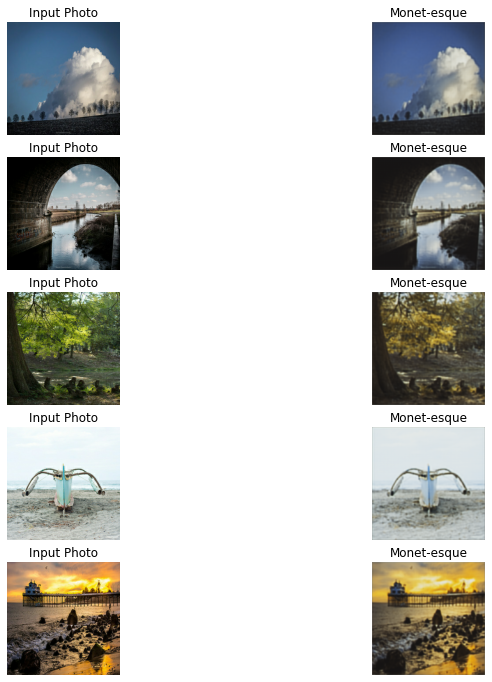

In [17]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [18]:
import PIL
! mkdir ../images

# Creating A Submission File

In [19]:
#i = 1
#for img in photo_ds:
    #prediction = monet_generator(img, training=False)[0].numpy()
    #prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    #im = PIL.Image.fromarray(prediction)
    #im.save("../images/" + str(i) + ".jpg")
    #i += 1

In [20]:
#import shutil
#shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")